# Actividad 1

## Descripción del problema y/o anomalía.
En este caso, nos enfrentamos a una anomalía ya que las imágenes presentan un ruído conocido como "salt and pepper", por lo cual, realizaremos la implementación de un algoritmo para corregir dichas anomalías. Dicho algoritmo estará basado en el filtro de la mediana, el cual es muy recomendado para corregir este tipo de anomalías.

## Solución propuesta

Como solución propuesta, implementamos una clase (MedianFilter), la cual se encargará de realizar todo el proceso de cargar una imagen desde la carpeta de media (agregar el ruido de "salt and pepper") y posteriormente aplicar el filtro de la mediana con un algoritmo desarrollado, el cuál consiste en dado el tamaño del kernel, itera sobre los pixeles de la imagen para crear una ventana (sub-matriz) con ayuda del tamaño del kernel y por último ir aplicando la media.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import warnings

In [2]:
class WrongScale(Exception):
    """
    Raised when the scale value is not in 0-100
    """
    pass

In [3]:
class MedianFilter(object):
    """
    Class to apply median filter to fix an image with salt and pepper noise.
    By default, add the noise to the image, and then apply median filter to fix it.
    """
    
    BASE_DIR = os.getcwd()
    
    def __init__(self, img_path: str, min_pixels=None, max_pixels=None, kernel_size=None,
                scale_percent=None, resize=False):
        # relative path for the image
        self.img_path = img_path                             
        # min number of pixels to appy the salt&pepper filter
        self.min_pixels = 16000 if min_pixels is None else min_pixels
        # max number of pixels to appy the salt&pepper filter
        self.max_pixels = 26000 if max_pixels is None else max_pixels
        # kernel size to create the window
        self.kernel_size = 3 if kernel_size is None else kernel_size
        self.indexer = self.kernel_size // 2 
        # Percent of original size
        self.scale_percent = 60 if scale_percent is None else scale_percent        
        # If True, resize the image
        self.resize = resize
        # Image on gray scale (represented on a numpy ndarray)
        self.image = cv2.imread(self.BASE_DIR + img_path, cv2.IMREAD_GRAYSCALE)
        # image width
        self.width = int(self.image.shape[1])
        # image height
        self.height = int(self.image.shape[0])  
    
    
    def add_noise(self, image) -> np.ndarray:
        """
        Add salt & pepper noise to an image
        ...
        
        Attributes
        -----------
        image : np.ndarray
            Image represented on a numpy ndarray    
        min_pixels : None or int (optional)
            min number of pixels to appy the salt&pepper filter
        max_pixels : None or int (optional)
            max number of pixels to appy the salt&pepper filter
        """      
        pixels_interval = (self.min_pixels, self.max_pixels)
     
        # Getting the dimensions of the image
        row , col = image.shape
         
        # Randomly pick some pixels in the
        # image for coloring them white
        # Pick a random number
        number_of_pixels = random.randint(*pixels_interval)
        for i in range(number_of_pixels):
           
            # Pick a random y coordinate
            y_coord = random.randint(0, row - 1)
             
            # Pick a random x coordinate
            x_coord = random.randint(0, col - 1)
             
            # Color that pixel to white
            image[y_coord][x_coord] = 255
             
        # Randomly pick some pixels in
        # the image for coloring them black
        # Pick a random number
        number_of_pixels = random.randint(*pixels_interval)
        for i in range(number_of_pixels):
           
            # Pick a random y coordinate
            y_coord = random.randint(0, row - 1)
             
            # Pick a random x coordinate
            x_coord = random.randint(0, col - 1)
             
            # Color that pixel to black
            image[y_coord][x_coord] = 0
             
        return image
    
    def resize_image(self) -> np.ndarray:
        """
        Resize an image given an scale percent
        ...
        
        Attributes
        -----------
        image : np.ndarray
            Image to resize
        scale_percent : None or int (optional)
            the scale percent to resize
        """      
        # Validate the scale_percent
        if self.scale_percent < 0 or self.scale_percent > 100:
            raise WrongScale
            
        # Get new dimesion for the resized image
        width = int(self.width * self.scale_percent / 100)
        height = int(self.height * self.scale_percent / 100)
        dim = (width, height)
        
        # Resize image
        resized = cv2.resize(self.image, dim, interpolation = cv2.INTER_AREA)
        
        return resized
    
    
    def get_window_result(self, image, x, y) -> int:
        """
        Set the window where the median will be applied and return it
        ...
        
        Attributes
        -----------
        
        image : numpy.array
            Image in array representation
        x : int 
            x-coordinate
        y : int 
            y-coordinate        
        """
        y_start = y - self.indexer
        y_final = y + self.indexer + 1
        x_start = x - self.indexer
        x_final = x + self.indexer + 1    
        # slice the array in the window
        # given the image as an array, substract an array from the main array
        window = image[y_start:y_final, x_start:x_final]
        # avoid RuntimeWarning : Mean of empty slice
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            median = np.median(window)
        
        return median
    
    def median_filter(self) -> tuple:
        """
        Appy median_filter to fix an image with salt & pepper noise
        ...        
        
        Attributes
        -----------
        image : np.ndarray
            Image represented on a numpy ndarray
        kernel_size : None or int (optional)
            Filter size to apply the median 
        """                               
        image = self.resize_image() if self.resize is True else self.image
        image_with_noise = self.add_noise(image)
        height, width = image.shape         
        processed_image = np.zeros((height,width), dtype=np.uint8)
        start_x = start_y = self.indexer
        final_x = width - self.indexer
        final_y = height - self.indexer
        # loop over the image array to get the window, then calculate the median
        # and replace the current value with it
        for y in range(height):
            if y != start_y and y != final_y:            
                for x in range(width): 
                    if x != start_x and x != final_x:                         
                        median = self.get_window_result(image, x, y)                      
                        processed_image[y][x] = median                                   

        return (image_with_noise, processed_image)
    
    
    def show_results(self, img_with_noise: np.array, img_clear: np.array) -> None:
        """
        Plot the images
        """
        img_with_noise = cv2.cvtColor(img_with_noise, cv2.COLOR_BGR2RGB)
        img_clear = cv2.cvtColor(img_clear, cv2.COLOR_BGR2RGB)
        images = [img_with_noise, img_clear]
        titles = ["Salt & pepper noise", "Fixed"]        
        plt.figure(figsize=(35,35))
        for i in range(2):
          plt.subplot(3, 3, i+1)
          plt.imshow(images[i], vmin=0, vmax=255)
          plt.title(titles[i])
          plt.xticks([]),plt.yticks([])
        plt.show()        

## Imágenes con anomalías

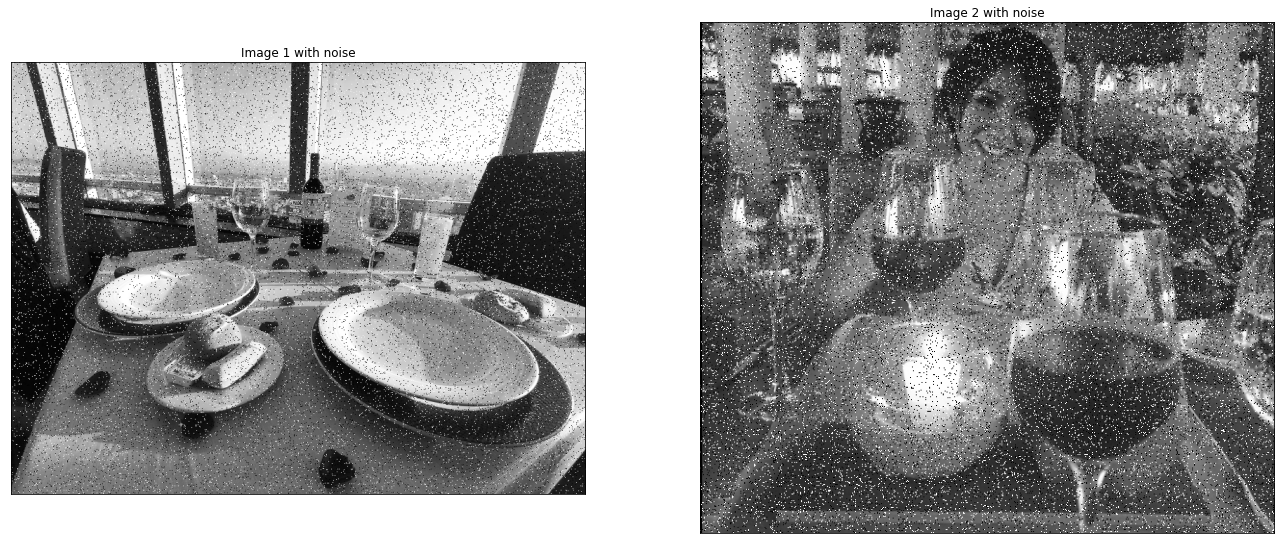

In [4]:
# Create the first object with the first image
first_image = MedianFilter(img_path="/media/ocaso.png", scale_percent=40, resize=True)
# Get the images (with noise and fixed)
img_with_noise1, img_clear1 = first_image.median_filter()

# Create the second object with the second image
second_image = MedianFilter(img_path="/media/cena.png", scale_percent=72, resize=True)
# Get the images (with noise and fixed)
img_with_noise2, img_clear2 = second_image.median_filter()

# Show the image
images = [cv2.cvtColor(img_with_noise1, cv2.COLOR_BGR2RGB), cv2.cvtColor(img_with_noise2,cv2.COLOR_BGR2RGB)]
titles = ["Image 1 with noise", "Image 2 with noise"]        
plt.figure(figsize=(35,35))
for i in range(2):
  plt.subplot(3, 3, i+1)
  plt.imshow(images[i], vmin=0, vmax=255)
  plt.title(titles[i])
  plt.xticks([]),plt.yticks([])

## Resultados

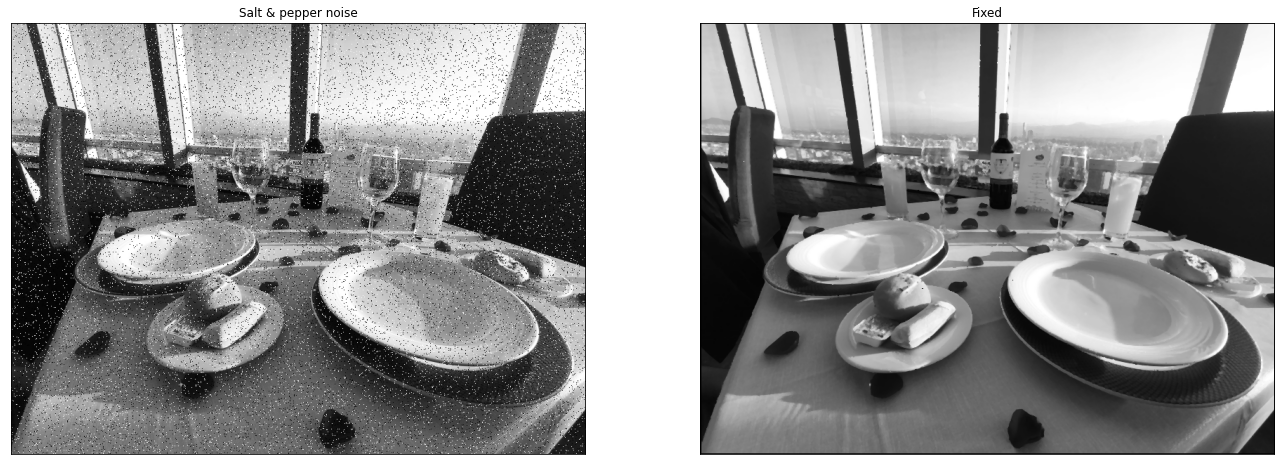

In [7]:
# Show the resutls
first_image.show_results(img_with_noise1, img_clear1)

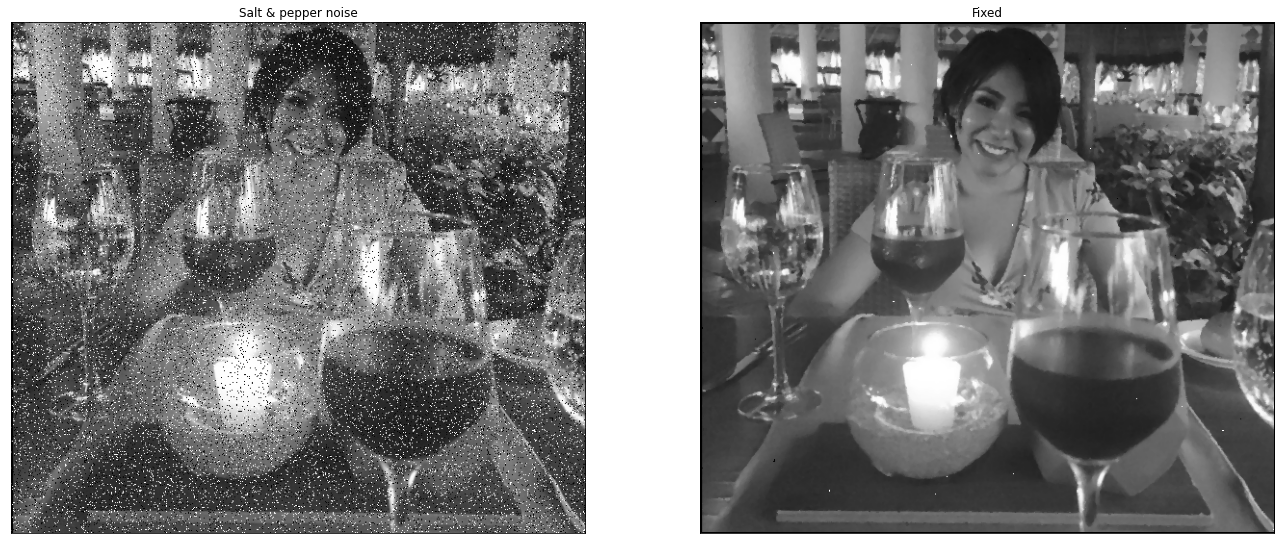

In [9]:
# Show the results
second_image.show_results(img_with_noise2, img_clear2)

## Referencias

add_noise: https://www.geeksforgeeks.org/add-a-salt-and-pepper-noise-to-an-image-with-python/

resize_image: https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/